# MNIST in Caffe

### Use model from https://elitedatascience.com/keras-tutorial-deep-learning-in-python

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt

# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (5, 5)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

In [3]:
# run scripts from caffe root
import os
os.chdir(caffe_root)
# Download data
!data/mnist/get_mnist.sh
# Prepare data
!examples/mnist/create_mnist.sh
# back to examples
os.chdir('examples')

Downloading...
Creating lmdb...
I0628 01:34:27.971473  2495 db_lmdb.cpp:35] Opened lmdb examples/mnist/mnist_train_lmdb
I0628 01:34:27.972055  2495 convert_mnist_data.cpp:88] A total of 60000 items.
I0628 01:34:27.972118  2495 convert_mnist_data.cpp:89] Rows: 28 Cols: 28
I0628 01:34:30.753105  2495 convert_mnist_data.cpp:108] Processed 60000 files.
I0628 01:34:31.620498  2497 db_lmdb.cpp:35] Opened lmdb examples/mnist/mnist_test_lmdb
I0628 01:34:31.621121  2497 convert_mnist_data.cpp:88] A total of 10000 items.
I0628 01:34:31.621160  2497 convert_mnist_data.cpp:89] Rows: 28 Cols: 28
I0628 01:34:32.059216  2497 convert_mnist_data.cpp:108] Processed 10000 files.
Done.


In [4]:
! pwd

/home/nvidia/caffe/examples


In [6]:
from pylab import *

In [7]:
caffe.set_mode_gpu()
### load the solver and create train and test nets
solver = None  
solver = caffe.AdamSolver('mnist/transfer_cnn_mnist_solver.prototxt')

In [9]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (50, 1, 28, 28)),
 ('label', (50,)),
 ('label_mnist_1_split_0', (50,)),
 ('label_mnist_1_split_1', (50,)),
 ('conv1', (50, 32, 26, 26)),
 ('relu1', (50, 32, 26, 26)),
 ('conv2', (50, 32, 24, 24)),
 ('relu2', (50, 32, 24, 24)),
 ('pool', (50, 32, 12, 12)),
 ('dropout_1', (50, 32, 12, 12)),
 ('flatten', (50, 4608)),
 ('dense_1', (50, 500)),
 ('relu3', (50, 500)),
 ('dropout_2', (50, 500)),
 ('dense_2', (50, 10)),
 ('dense_2_dense_2_0_split_0', (50, 10)),
 ('dense_2_dense_2_0_split_1', (50, 10)),
 ('accuracy', ()),
 ('loss', ())]

In [10]:
# just print the weight sizes (we'll omit the biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (32, 1, 3, 3)),
 ('conv2', (32, 32, 3, 3)),
 ('dense_1', (500, 4608)),
 ('dense_2', (10, 500))]

In [11]:
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)

{'accuracy': array(0.07000000029802322, dtype=float32),
 'loss': array(81.22299194335938, dtype=float32)}

train labels: [ 5.  0.  4.  1.  9.  2.  1.  3.]


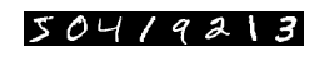

In [12]:
# we use a little trick to tile the first eight images
plt.imshow(solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray')
plt.axis('off')
print 'train labels:', solver.net.blobs['label'].data[:8]

test labels: [ 7.  2.  1.  0.  4.  1.  4.  9.]


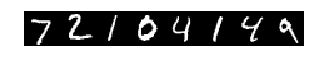

In [13]:
plt.imshow(solver.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray')
plt.axis('off')
print 'test labels:', solver.test_nets[0].blobs['label'].data[:8]

In [14]:
solver.step(1)

data


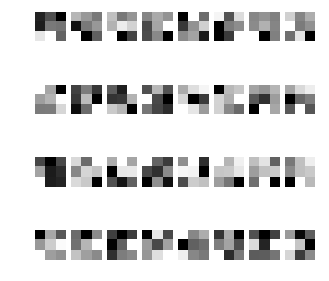

diff


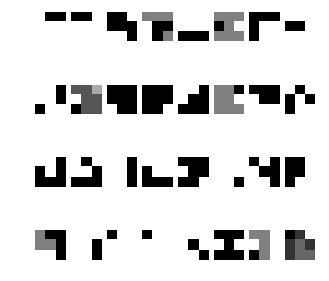

In [15]:
#print solver.net.params['conv1'][0].data.shape
#print solver.net.params['conv1'][0].diff.shape

fig = plt.figure()
print "data"
for i in range(0,32):
    data = solver.net.params['conv1'][0].data[i,0]
    a=fig.add_subplot(4,8,i+1)    
    plt.imshow(data, cmap='gray')
    plt.axis('off')
    #a.set_title(i+1)

plt.show()
fig.savefig('weights-step1.png')
fig = plt.figure()
print "diff"
for i in range(0,32):
    data = solver.net.params['conv1'][0].diff[i,0]
    a=fig.add_subplot(4,8,i+1)    
    plt.imshow(data, cmap='gray')
    plt.axis('off')
    #a.set_title(i+1)
    
plt.show()    
fig.savefig('w-deltas-step1.png')


In [22]:
caffe.set_mode_gpu()
### load the solver and create train and test nets
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
#solver = caffe.AdamSolver('mnist/transfer_cnn_mnist_solver.prototxt')
solver = caffe.AdamSolver('mnist/transfer_cnn_mnist_solver.prototxt')

In [23]:
#%%time
niter = 1200
test_interval = 100
text_inter = 100
# losses will also be stored in the log
train_loss = zeros(niter)
train_acc = zeros(niter)
test_loss = zeros(niter // test_interval)
test_acc = zeros(niter // test_interval)
output = zeros((niter, 8, 10))

# the main solver loop
for it in range(niter):
    solver.step(1)  
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    train_acc[it] = solver.net.blobs['accuracy'].data
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['dense_2'].data[:8]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        #print 'Iteration', it, 'testing...'
        acc_ = 0
        loss_ = 0
        for test_it in range(text_inter):
            solver.test_nets[0].forward()
            acc_ += solver.test_nets[0].blobs['accuracy'].data
            loss_ += solver.test_nets[0].blobs['loss'].data
        test_acc[it // test_interval] = acc_ / text_inter
        test_loss[it // test_interval] = loss_ / text_inter
        #print "Round ", it, test_interval, it // test_interval
        print "Test acc:", test_acc[it // test_interval],"Loss:", test_loss[it // test_interval]
      

Test acc: 0.124000000246 Loss: 76.428094635
Test acc: 0.856600000262 Loss: 11.9408595479
Test acc: 0.772800002098 Loss: 14.9147194576
Test acc: 0.0961000002548 Loss: 2.80770438433
Test acc: 0.114599999785 Loss: 2.40915092468
Test acc: 0.114499999471 Loss: 2.3519495821
Test acc: 0.114199999608 Loss: 2.33092683554
Test acc: 0.114199999534 Loss: 2.32236907721
Test acc: 0.114099999554 Loss: 2.32031453371
Test acc: 0.10339999998 Loss: 2.31639430285
Test acc: 0.101300000139 Loss: 2.3145284605
Test acc: 0.101300000139 Loss: 2.31464834929


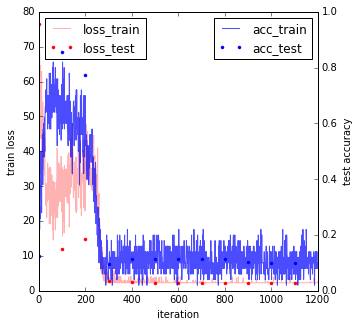

In [28]:
def plot_loss_accuracy(train_loss, test_loss, train_acc, test_acc, filename) :
    _, ax1 = subplots()
    ax2 = ax1.twinx()
    ax1.plot(arange(niter), train_loss, 'r-',label= "loss_train",alpha=0.3)
    ax1.plot(test_interval * arange(len(test_acc)), test_loss, 'r.',label= "loss_test")
    ax2.plot(arange(niter), train_acc, 'b-',label= "acc_train",alpha=0.7)
    ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'b.',label= "acc_test")
    #ax1.set_ylim([0,9])
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('train loss')
    ax2.set_ylabel('test accuracy')

    ax2.set_ylim([0,1])
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.savefig(filename)
    
plot_loss_accuracy(train_loss, test_loss, train_acc, test_acc, "AccLoss.png")    

In [216]:
# Reset solver
caffe.set_mode_gpu()
### load the solver and create train and test nets
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
#solver = caffe.AdamSolver('mnist/transfer_cnn_mnist_solver.prototxt')
solver = caffe.SGDSolver('mnist/transfer_cnn_mnist_solver.prototxt')

In [217]:
%%time
niter = 1200
test_interval = 100
test_iter = 50
# losses will also be stored in the log
train_loss = zeros(niter)
test_acc = zeros(niter // test_interval +1)
check_acc = zeros(niter // test_interval +1)
output = zeros((niter, 8, 10))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['dense_2'].data[:8]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        #print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(test_iter):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['dense_2'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / test_iter /100.
        check_acc[it // test_interval] = solver.test_nets[0].blobs['accuracy'].data
        #print "Round ", it, test_interval, it // test_interval
        print "Test acc:", test_acc[it // test_interval], "Check:",check_acc[it // test_interval], "Loss:", train_loss[it]
        

Test acc: 0.14 Check: 0.15000000596 Loss: 82.0963439941
Test acc: 0.11 Check: 0.119999997318 Loss: 2.29541873932
Test acc: 0.11 Check: 0.140000000596 Loss: 2.30103468895
Test acc: 0.11 Check: 0.119999997318 Loss: 2.29891872406
Test acc: 0.11 Check: 0.140000000596 Loss: 2.30302739143
Test acc: 0.11 Check: 0.119999997318 Loss: 2.29741430283
Test acc: 0.11 Check: 0.140000000596 Loss: 2.30490636826
Test acc: 0.11 Check: 0.119999997318 Loss: 2.30084586143
Test acc: 0.11 Check: 0.140000000596 Loss: 2.30100011826
Test acc: 0.11 Check: 0.119999997318 Loss: 2.30669736862
Test acc: 0.11 Check: 0.140000000596 Loss: 2.30700469017
Test acc: 0.11 Check: 0.119999997318 Loss: 2.29547357559
CPU times: user 1min 2s, sys: 19.1 s, total: 1min 21s
Wall time: 1min 9s


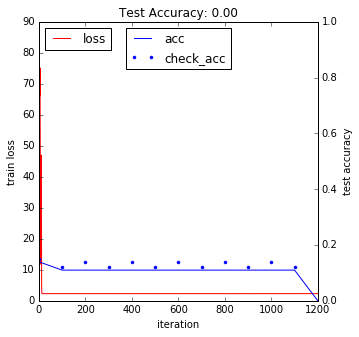

In [218]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss, 'r-', label= "loss")
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'b', label="acc")
ax2.plot(test_interval * arange(len(test_acc)), check_acc, 'b.', label="check_acc")
#ax1.set_ylim([0,9])
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))
ax2.set_ylim([0,1])
ax1.legend(loc='upper left')
ax2.legend(loc='upper center')
plt.savefig("AccLoss1.png")

In [136]:
import caffe
import lmdb
import PIL.Image
from StringIO import StringIO
import numpy as np

lmdb_dir = 'mnist/mnist_train_lmdb/'

cursor = lmdb.open(lmdb_dir, readonly=True).begin().cursor()
#datum = caffe.proto.caffe_pb2.Datum()

i = 0
for key, value in cursor:
#    datum.ParseFromString(value)
#    label = datum.label
#    data = caffe.io.datum_to_array(datum)
    #print label
    #imshow(data.reshape(28,28))
    #plt.axis('off')
    #plt.show()
    i = i+1
    #if i > 5:
    #    break
        
print i

lmdb_dir = 'mnist/mnist_test_lmdb/'

cursor = lmdb.open(lmdb_dir, readonly=True).begin().cursor()
#datum = caffe.proto.caffe_pb2.Datum()

i = 0
for key, value in cursor:
#    datum.ParseFromString(value)
#    label = datum.label
#    data = caffe.io.datum_to_array(datum)
    #print label
    #imshow(data.reshape(28,28))
    #plt.axis('off')
    #plt.show()
    i = i+1
    #if i > 5:
    #    break
        
print i

60000
10000


In [165]:
print solver.test_nets[0].blobs['dense_2'].data.shape
print solver.test_nets[0].blobs['accuracy'].data


(100, 10)
0.109999999404


In [158]:
print solver.test_nets[0].blobs['label'].data


[ 8.  9.  0.  1.  2.  3.  4.  5.  6.  7.  8.  0.  1.  2.  3.  4.  7.  8.
  9.  7.  8.  6.  4.  1.  9.  3.  8.  4.  4.  7.  0.  1.  9.  2.  8.  7.
  8.  2.  6.  0.  6.  5.  3.  3.  3.  9.  1.  4.  0.  6.  1.  0.  0.  6.
  2.  1.  1.  7.  7.  8.  4.  6.  0.  7.  0.  3.  6.  8.  7.  1.  5.  2.
  4.  9.  4.  3.  6.  4.  1.  7.  2.  6.  5.  0.  1.  2.  3.  4.  5.  6.
  7.  8.  9.  0.  1.  2.  3.  4.  5.  6.]


In [163]:
print(sum(solver.test_nets[0].blobs['dense_2'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data) / 100.)

0.11
